<a href="https://colab.research.google.com/github/leaBroe/random/blob/main/Run_ImmunoMatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>ImmunoMatch</h1>
<p align="center">
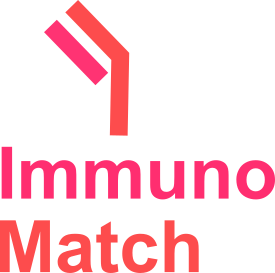
</p>
<div style="flex: 2;">
<br></br>
    <p><strong>ImmunoMatch</strong> is a language model fine-tuned from
      <a href="https://www.biorxiv.org/content/10.1101/2023.12.12.569610v1" style="color: #0073e6; text-decoration: none;">AntiBERTa2</a>
      to investigate the pairing between the heavy and light chains of antibodies.
    </p>
    <h3 style="margin-bottom: 10px;">How to Access</h3>
    <ul style="padding-left: 20px; line-height: 1.6;">
      <li>You can directly access <strong>ImmunoMatch</strong> from the checkpoints on
        <a href="https://huggingface.co/fraternalilab/immunomatch" style="color: #0073e6; text-decoration: none;">Hugging Face</a>.
      </li>
      <li>This
        <a href="https://colab.research.google.com/drive/1zhPkM69qxRKH07g9DydLv8ovvwsbflwa#scrollTo=vW26pWmnpvkX" style="color: #0073e6; text-decoration: none;">Colab notebook</a>
        provides examples of how to run <strong>ImmunoMatch</strong> and generate pairing scores. You can input <b>single</b> VH-VL pair, or upload a csv of multiple VH-VL pairs, in which the pairing scores will be predicted <b>in batches</b>.
      </li>
    </ul>
  </div>
</div>
<hr style="border: none; border-top: 1px solid #ddd; margin-top: 20px;">

In [8]:
# @title Import the dependencies
# @markdown Please execute this cell by pressing the Play button on the left to download and import dependencies in this Colab notebook.

# @markdown This will both import external python libraries, and the customized functions we wrote for easier access of the model. <b>This could take one and a half minutes. </b>
# install dependencies
! pip install datasets
! pip install rjieba
#! wget https://github.com/DongjunGuo/compiled_igblast_human/raw/refs/heads/main/ncbi-igblast-1.21.0.tar.gz
#! tar -xzvf ncbi-igblast-1.21.0.tar.gz

from transformers import (
        RoFormerTokenizer,
        pipeline,
        RoFormerForSequenceClassification,
        Trainer,TrainingArguments
    )

import pandas as pd
import numpy as np

import torch
from datasets import load_dataset

from sklearn.metrics import roc_curve,roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns

from functools import partial

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

import shutil
from google.colab import files
import os

# Functions for the calculation of the pairing score for single VH-VL
def preprocess_single_seq(seq):
  """
  Add the gap between adjacent amino acids, so that the model treat each amino acid as an individual token.
  args: input: seq: a string of amino acids
  """
  return " ".join(list(seq))

def pairing_score_single_pair (h_seq,l_seq,model_checkpoint):
  """
  Output the pairing score of a single pair of VH and VL sequences
  args:input:
  h_seq: a gapped sequence outputted from the function preprocess_seq
  l_seq: a gapped sequence outputted from the function preprocess_seq
  model_checkpoint: the checkpoint of the version of the immunoMatch of your interest
  """
  tokenizer = RoFormerTokenizer.from_pretrained(model_checkpoint)
  model=RoFormerForSequenceClassification.from_pretrained(model_checkpoint)
  model_output=model(**tokenizer(h_seq,l_seq,return_tensors="pt",padding="max_length",max_length=256))
  pairing_score=torch.nn.functional.softmax(model_output.logits, dim=1)[0][1].item()
  return pairing_score


# Functions for the calculation of the pairing score for batches of VH-VL

def preprocess_seq(example,hseqcol="input_Hseq",lseqcol="input_Lseq"):
    return {"input_Hseq":" ".join(list(example[hseqcol])), "input_Lseq":" ".join(list(example[lseqcol]))}

def tokenize_function(examples, tokenizer, hseqcol="input_Hseq",lseqcol="input_Lseq",max_length=256,return_tensors="pt"):
    return tokenizer(examples[hseqcol], examples[lseqcol], padding="max_length", truncation=True, max_length=max_length, return_tensors=return_tensors)

def tokenize_the_datasets(df_dir,hseq_col,lseq_col,tokenizer):
    """
    Tokenize the datasets
    args:input:
    df_dir: str, the directory of the dataset
    hseq_col: str, the column name of the heavy chain sequence
    lseq_col: str, the column name of the light chain sequence
    """
    df=pd.read_csv(df_dir)
    datasets=load_dataset("csv", data_files={"test":df_dir})
    tokenized_datasets=datasets.map(partial(preprocess_seq,hseqcol=hseq_col,lseqcol=lseq_col))
    tokenized_datasets=tokenized_datasets.map(partial(tokenize_function,tokenizer=tokenizer),batched=True)
    return df, tokenized_datasets

def pairing_scores_batches (df_dir,hseq_col,lseq_col,model_checkpoint):
  """
  Load the model and make the pairing prediction on batches of sequences
  args:input:
  df_dir: the directory of the csv files holding the sequences of pairs of VH and VL sequences
  hseq_col: the column name of the column of VH sequences
  lseq_col: the column name of the column of VL sequences
  model_checkpoint: the chesck point of the version of ImmunoMatch of your interest
  """

  tokenizer = RoFormerTokenizer.from_pretrained(model_checkpoint)
  model=RoFormerForSequenceClassification.from_pretrained(model_checkpoint)

  df,tokenized_datasets = tokenize_the_datasets (df_dir, hseq_col, lseq_col, tokenizer)

  device="cuda" if torch.cuda.is_available() else "cpu"
  batch_size=48
  args = TrainingArguments(
    f"tmp",
    #evaluation_strategy = "no",
    save_strategy = "epoch",
    #learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    #num_train_epochs=5,
    #weight_decay=0.01,
    report_to="none"
    #load_best_model_at_end=True,
    #metric_for_best_model="accuracy",
    #push_to_hub=True,
)

  trainer = Trainer(
            model,
            args,
            tokenizer=tokenizer,
            )
  pred_result=trainer.predict(tokenized_datasets["test"])

  pairing_scores=torch.nn.functional.softmax(torch.tensor(pred_result.predictions),dim=1)[:,1].tolist()
  df["pairing_scores"]=pairing_scores

  return df


In [3]:
# @title Get the pairing score of single VH-VL pair
# @markdown This cell is used to calculate the pairing score of the VH-VL sequences pair you inputted, using the version of ImmunoMatch of your interest.

# @markdown #### Model Checkpoints
# @markdown Three versions of ImmunoMatch are available, including ImmunoMatch, ImmunoMatch-κ, and ImmunoMatch-λ. Please select the model checkpoint accordingly.
immunoMatch_version = 'fraternalilab/immunomatch-kappa' # @param ["fraternalilab/immunomatch", "fraternalilab/immunomatch-kappa", "fraternalilab/immunomatch-lambda"]
model_cp_single = immunoMatch_version
# @markdown #### VH-VL sequences
h_seq='EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSS' # @param {type:"string"}
l_seq='DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSRSGTDFTLTISSLQPEDFATYYCQQHYTTPPTFGQGTKVEIK' # @param {type:"string"}

h_seq_gapped=preprocess_single_seq(h_seq)
l_seq_gapped=preprocess_single_seq(l_seq)
pairing_score_single=pairing_score_single_pair (h_seq_gapped,l_seq_gapped,model_cp_single)

print (f"\n\n\n Pairing score for the inputted H-L pair: {pairing_score_single}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/811M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/811M [00:00<?, ?B/s]




 Pairing score for the inputted H-L pair: 0.8628443479537964


## Run ImmunoMatch on a batch of sequences

In [4]:
# @title Example input data
# @markdown You can organize your data as a csv file, with each row indicating a VH-VL pair, and columns holding VH, VL amino acid sequences seperately. Here we show you the example dataset so that you get a feeling of the structure of input data. The example dataset is sampled from [King et al., 2021](https://www.science.org/doi/10.1126/sciimmunol.abe6291), where B cell sequences from germinal centre are collected. Explaination on each columns in the data are listed below:

# @markdown <b> barcode:</b> The barcode of the cell indicating the pairing identity.
# @markdown <br><b> VH: </b> Sequences of the VH domains.</br>
# @markdown <b> VL: </b> Sequences of the VL domains.
# @markdown <br><b> locus: </b> This column indicates the type of the L chain: κ or λ.</br>
# @markdown <br> Your uploaded csv file should contain the information covered in the <b> VH, VL, locus </b> columns.

# Get the sample data from https://www.science.org/doi/10.1126/sciimmunol.abe6291
# ! wget -O King_Tonsil_GC_paired.csv https://github.com/Fraternalilab/ImmunoMatch/raw/refs/heads/main/King_Tonsil_GC_paired.csv

#gc_data=pd.read_csv("King_Tonsil_GC_paired_subset.csv").head(n=100)
gc_data=pd.read_csv("https://github.com/Fraternalilab/ImmunoMatch/raw/refs/heads/main/example_input/King_Tonsil_GC_paired.csv").head(n=100)
gc_data

,sample_name,barcode,VH,VL,locus
0,BCP003_MBC,BCP3_MBC_AACACGTCAATGAATG,QVHLVESGGGVVQPGKSLRLSCAATGFTFSNYGMHWVRQAPGKGLE...,DIQMTQSPSTLSASVGDRVSITCRASQSISSWLAWYQQKPGKAPKL...,IGK
1,BCP003_MBC,BCP3_MBC_CAGATCATCTGATTCT,QVQLQESGPGLVKPSGTLSLTCAVSGGSISSTNWWTWVRQPPGKGL...,EIVLTQSPGTLSLSPGERATLSCRASQGVSSTYLAWYQQKPGQAPR...,IGK
2,BCP003_MBC,BCP3_MBC_CGGGTCAAGCTGGAAC,QVQLQESGPRLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,EIKLTQSPATLSVSPGERATLSCRASQSVRSNLAWYQQKPGQTPRL...,IGK
3,BCP003_MBC,BCP3_MBC_CTCGTACCAGTATGCT,QVQVMQSGAEMKKPGASVKVSCKASGYTFTSYPLHWVRQAPGQRLE...,DIQMTQSPSTLSASVGDRVTITCRASQTISSWLAWYQHKPGKAPNL...,IGK
4,BCP003_Total,BCP3_Total_AAAGATGAGCCGATTT,EVHLVESGGGLVQPGGSLRLSCAASGFTLSRYWMSWIRQAPGKGLE...,EIVMTQSPATLSVSPGERATLSCRASQSVSSNLAWYQQKPGQAPRL...,IGK
...,...,...,...,...,...
95,BCP003_Total,BCP3_Total_GAGGTGAGTGTGGTTT,EVQLLESGGGLVQAGGSLRLSCVGTGFTFSHFAMSWVRQAPGTGLE...,IVLTQSPATLSSSLGERVTLFCGAGRTLSTNYLAWYQQKRGLAPKL...,IGK
96,BCP003_Total,BCP3_Total_GATCAGTAGTGTTAGA,QVNLVESGGGVVQPGRSLRLSCAASGFTFSNFAMHWVRQAPGKGLE...,DIQMTQSPSTLSASVGDRVTITCRASQSISSWLAWYQQKPGKAPKL...,IGK
97,BCP003_Total,BCP3_Total_GATCAGTGTGTTCGAT,QVQLVQSGAEVKKPGASVKVSCKASGYTLTSHYIYWVRQAPGQGLE...,DIVMTQSPVSLPVTPGEPASISCRSSQSLLHSNEYNYLDWYLQKPG...,IGK
98,BCP003_Total,BCP3_Total_GATTCAGAGCTTCGCG,EVQLEQSGAEVKKPGESLKISCKGSGYSFTTYWIGWVRQMPGKGLE...,SYELTQPPSVSVSPGQTARITCSGDALPKQYAYWYQQKPGQAPVLV...,IGL


In [11]:
# @title Your input data
# @markdown Here, you input your csv file. First go to the "Files" tab at the left side of this Colab notebook to upload your data file. Then input the directory of your csv file here. <em>Or</em> paste the url of the csv file to here directly.


# @markdown After this, please indicate the names of the column holding <b>L chain type, VH and VL sequences</b> here.

data_dir="/content/rel_cols_full_PLAbDab_healthy_human_nucleus_bert2gpt_nucleus_healthy_human_PLAbDab_max_new_tokens_115_num_epochs_50_bert_like_tokenizer_unpaired_epo_41-7.csv" # @param {type:"string", placeholder:"enter a value"}
hseq_col_name="input_heavy_sequence" # @param {type:"string", placeholder:"enter a value"}
lseq_col_name="generated_sequence_light" # @param {type:"string", placeholder:"enter a value"}
Ltype_col_name="locus_light" # @param {type:"string", placeholder:"enter a value"}

data=pd.read_csv(data_dir)
data

,input_heavy_sequence,sequence_alignment_aa_light_1,generated_sequence_light,sequence_alignment_heavy_sep_light,locus_light
0,QLQVQESGPGLVKPSETLSLTCTVSGASSSIKKYYWGWIRQSPGKG...,DIQMTQSPSTLSASVGDRVTITCRASHSINTWLAWYQQKPGKAPKL...,DIVMTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKP...,QLQVQESGPGLVKPSETLSLTCTVSGASSSIKKYYWGWIRQSPGKG...,IGK
1,QLQLQESGPGLVKPSETLSLICSVSGGSITTSSYYWAWIRQSPGKG...,QSALTQPASVSGSPGQSITISCSGTSDDIGDYNYVSWYQQHPGKAP...,DIQMTQSPSSLSASVGDRVTITCRASQSISTYLNWYQQKPGKAPKL...,QLQLQESGPGLVKPSETLSLICSVSGGSITTSSYYWAWIRQSPGKG...,IGL
2,EVQLVESGGDLVRPGGSLRLSCAASGFPFSRAWMTWVRQAPGKGLD...,DIQMTQSPSSLSAFMGDRVTITCRASQSPKTYLHWYQQRPGGVPKL...,DIVMTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKP...,EVQLVESGGDLVRPGGSLRLSCAASGFPFSRAWMTWVRQAPGKGLD...,IGK
3,EVQLLESGGGLVQPGGSLRLSCAASGFNFANYDMSWVRQAPGKGLE...,QTVVTQEPSFSVSPGGTVTLTCGLSSGSVSTKYYPSWYQQTPGQAP...,DIQMTQSPSTLSASVGDRVTITCRASQSISSWLAWYQQKPGKAPKL...,EVQLLESGGGLVQPGGSLRLSCAASGFNFANYDMSWVRQAPGKGLE...,IGL
4,QVQLQESGPGLVKPSGTLSLTCVVSGGSISTNNWWSWVRQPPGKGL...,EIVLTQSPGTLSLSPGERATLSCRASQSISNTYLAWYRQKPGQAPR...,QSALTQPASVSGSPGQSITISCTGTSSDVGGYNYVSWYQQHPGKAP...,QVQLQESGPGLVKPSGTLSLTCVVSGGSISTNNWWSWVRQPPGKGL...,IGK
...,...,...,...,...,...
52133,QVSLRESGPALVKPTETLTLTCAFSGFSLSSSGVSVNWVRQPPGKA...,SYELTQPPSVSVSPGQTARIPCSGETLPKQYTFWYQQKPGQAPVLV...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQQLPGTAP...,QVSLRESGPALVKPTETLTLTCAFSGFSLSSSGVSVNWVRQPPGKA...,IGL
52134,QVHLVQSGAEVKKPGASVKVSCMPSGYTFTAYFIHWVRQAPGQGLE...,DIQMTQSPSTLSASVGDRVTITCRASQSISKWLAWYQQKPGRGPTF...,EIVLTQSPGTLSLSPGERATLSCRASQSVSSNYLAWYQQKPGQAPR...,QVHLVQSGAEVKKPGASVKVSCMPSGYTFTAYFIHWVRQAPGQGLE...,IGK
52135,EVHLEQSGGVVVQPGGSLRLSCAASGFKFDDYAMHWVRQVPGKGLQ...,IQLTQSPSSLSASVGDRVTITCRASQDIDSHLAWYQRKLGKAPRLL...,EIVLTQSPATLSLSPGERATLSCRASQSVSTYLAWYQQKPGQAPRL...,EVHLEQSGGVVVQPGGSLRLSCAASGFKFDDYAMHWVRQVPGKGLQ...,IGK
52136,QVQLQESGPGLVKPSETLSLRCTVSDRSISTHFWNWIRRPAGKGLE...,EIVLTQSPGSLSLSLGERATLSCRASQVVSNSFLAWYYHKPGQAPR...,EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPR...,QVQLQESGPGLVKPSETLSLRCTVSDRSISTHFWNWIRRPAGKGLE...,IGK


In [12]:
# @title Run ImmunoMatch on batches
# @markdown Now it's the time to get all the pairing scores for the sequences collected in your data file! Select the version of the ImmunoMatch according to your research interest, then wait for several mins to hours to get the results, based on the number of sequences and the available computational resources.

# @markdown <b>The results will be downloaded automatically once the calculation is finished.</b>

#model_checkpoint_batch ='fraternalilab/immunomatch' # @param ["fraternalilab/immunomatch", "fraternalilab/immunomatch-kappa", "fraternalilab/immunomatch_lambda"]

kappa_data = data.loc[data["locus_light"].apply(lambda x: "IGK" in x)]
lambda_data = data.loc[data["locus_light"].apply(lambda x: "IGL" in x)]

k_data_dir = "kappa_data.csv"
l_data_dir = "lambda_data.csv"
kappa_data.to_csv(k_data_dir, index=False)
lambda_data.to_csv(l_data_dir, index=False)

k_pairing_batch_result = pairing_scores_batches(k_data_dir,hseq_col_name,lseq_col_name, "fraternalilab/immunomatch-kappa")
l_pairing_batch_result = pairing_scores_batches(l_data_dir,hseq_col_name,lseq_col_name, "fraternalilab/immunomatch-lambda")

pairing_batch_result = pd.concat([k_pairing_batch_result, l_pairing_batch_result]).sort_index()

# save the result
f_name=data_dir.split("/")[-1]
pairing_batch_result.to_csv(f"pairing_result_{f_name}")

# download the result
output_dir="prediction"
os.makedirs(output_dir, exist_ok=True)

os.rename(f"pairing_result_{f_name}",f"{output_dir}/pairing_result_{f_name}")

shutil.make_archive(output_dir, format='zip', root_dir=output_dir)
files.download(f'{output_dir}.zip')




Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/33875 [00:00<?, ? examples/s]

Map:   0%|          | 0/33875 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/18263 [00:00<?, ? examples/s]

Map:   0%|          | 0/18263 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: xlabel='pairing_scores', ylabel='Density'>

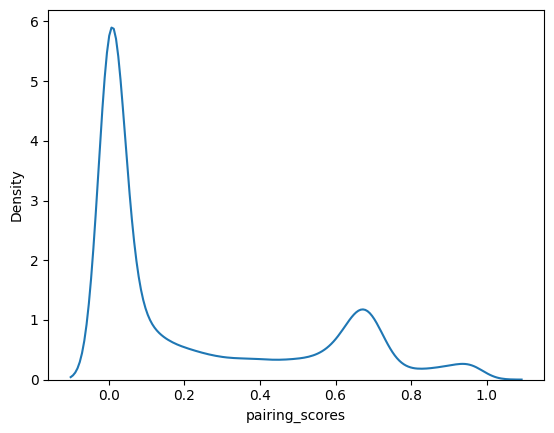

In [13]:
# @title Simple visualization of the predicted pairing scores
sns.kdeplot(pairing_batch_result, x="pairing_scores")